In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch.nn.functional as F
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [41]:
# data processing For ARIMA
raw_data = pd.read_csv('Data.csv')
print(raw_data)
data_name = 'Covid-19 infection cases in India'


            Date  Cases
0     22.01.2020      0
1     23.01.2020      0
2     24.01.2020      0
3     25.01.2020      0
4     26.01.2020      0
...          ...    ...
1029  16.11.2022    635
1030  17.11.2022   -568
1031  18.11.2022   1781
1032  19.11.2022    492
1033  20.11.2022    406

[1034 rows x 2 columns]


In [3]:

train_len = 828

In [4]:
ARIMA_close_prices = raw_data['Cases'].values.astype(float)
#len(sp500_close_prices)

def create_sequences(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

#Data normalization
scaler = MinMaxScaler()
training_data = scaler.fit_transform(ARIMA_close_prices.reshape(-1,1))

seq_length = 8
x, y = create_sequences(training_data, seq_length)

train_size = int(0.8*train_len)
validate_size = int(0.2*train_len)   # set by hand

test_size = len(y) - train_size - validate_size
print(len(y))
print(test_size)

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

X_train = torch.Tensor(np.array(x[0:train_size]))
Y_train = torch.Tensor(np.array(y[0:train_size]))

training_dataset = TensorDataset(X_train,Y_train)
train_loader = DataLoader(training_dataset, num_workers=1, shuffle=True,batch_size = 64,drop_last = True)

X_validate = torch.Tensor(np.array(x[train_size:train_size+validate_size]))
Y_validate = torch.Tensor(np.array(y[train_size:train_size+validate_size]))

validate_dataset = TensorDataset(X_validate,Y_validate)
validate_loader = DataLoader(validate_dataset, num_workers=1, shuffle=True,batch_size = 64,drop_last = True)

X_test = torch.Tensor(np.array(x[train_size+validate_size:len(x)]))
Y_test = torch.Tensor(np.array(y[train_size+validate_size:len(y)]))
print(X_train[0],Y_train[0])
print(X_train[1],Y_train[1])

1025
198
tensor([[0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029]]) tensor([0.0029])
tensor([[0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029]]) tensor([0.0029])


In [5]:
class AttnDecoder(nn.Module):

    def __init__(self, code_hidden_size, hidden_size, time_step):
        super(AttnDecoder, self).__init__()
        self.code_hidden_size = code_hidden_size
        self.hidden_size = hidden_size
        self.T = time_step

        self.W = nn.Linear(in_features=2 * hidden_size, out_features=code_hidden_size)
        self.U = nn.Linear(in_features=code_hidden_size, out_features=code_hidden_size)
        self.tanh = nn.Tanh()
        self.V = nn.Linear(in_features=code_hidden_size, out_features=1)
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.tilde = nn.Linear(in_features=self.code_hidden_size + 1, out_features=1)
        self.fc1 = nn.Linear(in_features=code_hidden_size + hidden_size, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, encoder_output, y_seq, d , s):
        y_seq = y_seq.transpose(0,1)  #   1*64*1 -->64*1*1
        encoder_output = encoder_output.transpose(0,1)  # [8, 64, 16]->[64, 8, 16]

        # (seq_len, batch,  hidden_size):    
        batch_size = encoder_output.size(0)  
#         d = self.init_variable(1, batch_size, self.hidden_size)#. [1, 64, 16]
#         s = self.init_variable(1, batch_size, self.hidden_size)
        
        ct = self.init_variable(batch_size, self.hidden_size)    # [64, 16]
        
        for t in range(self.T):
            # batch_size * time_step * (encoder_hidden_size + decoder_hidden_size)
            # [time_step, 64, 16] ->[64 , tstep, 16] 
          
            h = encoder_output  # [64, 8, 16]
            d_s = torch.cat((self.embedding_hidden(d), self.embedding_hidden(s)), 2)    # [64 , 1, 16*2]
            z1 = self.W(d_s)  # [64 ,1, 16*2]-> [64 , 1, 16]
            z2 = self.U(h)  # [64, 8, 16]->[64, 8, 16]
            x = z1 + z2  # [64, 1, 16] + [64, 8, 16] = [64, 8, 16]
            z3 = self.V(self.tanh(x))   #   [64, 8, 16]->[64, 8, 1]

            beta_t = F.softmax(z3.view(batch_size, -1), dim=1)
            # yc 64*1*1
            # h [64, 8, 16]

            # [64, 1, 8] * [64, 8, 16] = [64, 1, 16] -> [64, 16]   batch_size * encoder_hidden_size
            ct = torch.bmm(beta_t.unsqueeze(1), h).squeeze(1)  # [64, 16]
            
            y_past = y_seq[:,t,:] # [64, 1]
            yc = torch.cat((y_past, ct), dim=1)  
            y_tilde = self.tilde(yc)
            _, states = self.lstm(y_tilde.unsqueeze(0), (d, s))    # [1, 64, 1]  [1, 64, 16]
            d = states[0]
            
        y_res = self.fc2(self.fc1(torch.cat((d.squeeze(0), ct), dim=1)))
        return y_res

    def init_variable(self, *args):
        zero_tensor = torch.zeros(args)
        if torch.cuda.is_available():
            zero_tensor = zero_tensor.cuda()
        return Variable(zero_tensor)

    def embedding_hidden(self, x):
        return x.repeat(self.T, 1, 1).permute(1, 0, 2)

    
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size,num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size,num_layers)

        
    def forward(self, x):

        
        # Propagate input through LSTM
      
        output, (hidden_out, cell_out) = self.lstm(x)
        
        return output, (hidden_out, cell_out)
    
    
class Decoder(nn.Module):
    
    def __init__(self, input_size, hidden_size,num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
  
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers)
        
        
    def forward(self,x,hidden,cell):
        
        
     
        output, (hidden_out, cell_out) = self.lstm(x, (hidden, cell))
        
        return output, (hidden_out, cell_out)

class Seq2Seq(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,out_dims,attention_flag = False):
        super().__init__()
        self.attention_flag = attention_flag
        self.encoder = Encoder(input_size,hidden_size,num_layers)
        if self.attention_flag == True:
            self.decoder = AttnDecoder(hidden_size, hidden_size, 1)
        if self.attention_flag == False:
            self.decoder = Decoder(input_size,hidden_size,num_layers)

        self.fc = nn.Linear(hidden_size, out_dims)
        
        
    def forward(self, enc_input, dec_input):
        
        encoder_output,(h_out,c_out) = self.encoder(enc_input)  # torch.Size([64, 8, 1])

        #dec_input [64, 1, 1]     
        # h_out  [1, 64, 16]
        
        if self.attention_flag == True:
            y_res = self.decoder(encoder_output, dec_input,h_out,c_out)
        if self.attention_flag == False:
            _, (decoder_h_out, _) = self.decoder(dec_input,h_out,c_out)
            y_res = self.fc(decoder_h_out)

       
        return y_res

In [28]:
num_epochs = 100
learning_rate = 0.005
input_dim = 1
hidden_size = 32
num_layers = 1
output_dim = 1
output_length = 1
attention_flag = False

model = Seq2Seq(input_dim,hidden_size,num_layers,output_dim,attention_flag)

#model = simpleLSTM(num_classes, input_size, hidden_size, num_layers)
# model = Seq2Seq_model(input_dim, hidden_size,num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 32)
  )
  (decoder): Decoder(
    (lstm): LSTM(1, 32)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [29]:
# Train the model
history = {}
history['accuracy'] = []
history['val_accuracy'] = []
history['loss'] = []
history['val_loss'] = []
for epoch in range(num_epochs):
    epoch_loss, epoch_val_loss = 0, 0
    for data in train_loader:
        X_train,Y_train = data
        Y_train = Y_train.unsqueeze(0)

        model.train()
        # decoder 的输入
        decoder_input = torch.zeros(64,1,1).transpose(0,1)

        #decoder_input = X_train[:,-1,:].unsqueeze(1)
        train_pred = model(X_train.transpose(0,1), decoder_input)
        
        # obtain the loss function
        train_loss = criterion(train_pred, Y_train)
        train_loss.backward(retain_graph=True) #backpropagation
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        
        for valdiate_data in validate_loader:
            X_validate,Y_validate = valdiate_data
            #decoder_input = X_validate[:,-1,:].unsqueeze(1)
            validate_pred =  model(X_validate.transpose(0,1),decoder_input)
            validate_loss = criterion(validate_pred,Y_validate)
            epoch_loss += float(train_loss)
            epoch_val_loss += float(validate_loss)
    # history['accuracy'].append(torch.sum((train_pred.squeeze() > 0.5) == Y_train.squeeze()) / len(train_pred.squeeze()))
    # history['val_accuracy'].append(torch.sum((validate_pred.squeeze() > 0.5) == Y_validate.squeeze()) / len(validate_pred.squeeze()))

    history['loss'].append(epoch_loss)
    history['val_loss'].append(epoch_val_loss)
    if epoch % 1 == 0:
        print("Epoch: %d, train_loss: %1.5f,validate_loss: %1.5f" % (epoch, train_loss,validate_loss))

c:\Users\Amr\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([1, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, train_loss: 0.05241,validate_loss: 0.03841
Epoch: 1, train_loss: 0.01980,validate_loss: 0.02810
Epoch: 2, train_loss: 0.00287,validate_loss: 0.00686
Epoch: 3, train_loss: 0.00202,validate_loss: 0.00721
Epoch: 4, train_loss: 0.00107,validate_loss: 0.00561
Epoch: 5, train_loss: 0.00232,validate_loss: 0.00733
Epoch: 6, train_loss: 0.00152,validate_loss: 0.00372
Epoch: 7, train_loss: 0.00119,validate_loss: 0.00516
Epoch: 8, train_loss: 0.00176,validate_loss: 0.00481
Epoch: 9, train_loss: 0.00096,validate_loss: 0.00673
Epoch: 10, train_loss: 0.00138,validate_loss: 0.00344
Epoch: 11, train_loss: 0.00090,validate_loss: 0.00381
Epoch: 12, train_loss: 0.00192,validate_loss: 0.00437
Epoch: 13, train_loss: 0.00048,validate_loss: 0.00286
Epoch: 14, train_loss: 0.00124,validate_loss: 0.00379
Epoch: 15, train_loss: 0.00036,validate_loss: 0.00273
Epoch: 16, train_loss: 0.00096,validate_loss: 0.00421
Epoch: 17, train_loss: 0.00094,validate_loss: 0.00228
Epoch: 18, train_loss: 0.00098,validat

In [30]:
decoder_input = torch.zeros(64,1,1).transpose(0,1)

#decoder_input = X_train[:,-1,:].unsqueeze(1)
train_pred = model(X_train.transpose(0,1), decoder_input)

In [31]:
decoder_input.shape

torch.Size([1, 64, 1])

In [32]:
X_train.transpose(0,1).shape

torch.Size([8, 64, 1])

In [33]:
from torchinfo import summary
summary(model, input_size=[(64, 8, 1), (64, 8, 1)])


Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 8, 1]                 --
├─Encoder: 1-1                           [64, 8, 32]               --
│    └─LSTM: 2-1                         [64, 8, 32]               4,480
├─Decoder: 1-2                           [64, 8, 32]               --
│    └─LSTM: 2-2                         [64, 8, 32]               4,480
├─Linear: 1-3                            [1, 8, 1]                 33
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
Total mult-adds (M): 4.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.04
Estimated Total Size (MB): 0.30

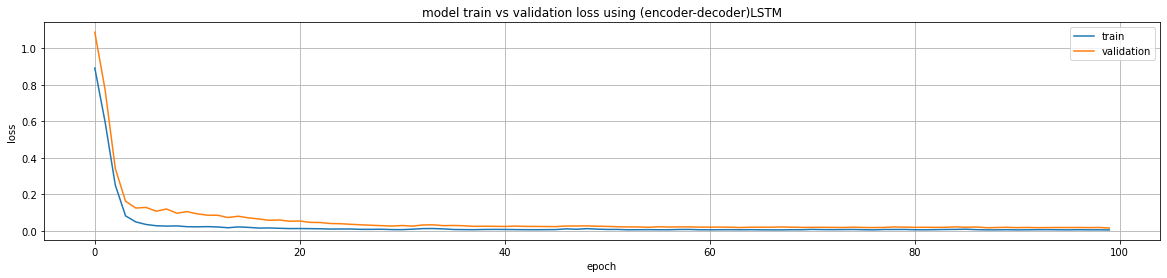

In [52]:
fig = plt.figure(figsize=(20,4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model train vs validation loss using (encoder-decoder)LSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()
fig.savefig('plot train and validation loss.png', dpi=fig.dpi, facecolor='white', bbox_inches='tight')

In [45]:
# save model
save_path = 'models/{}_lstm_model.zip'.format(data_name)
torch.save(model, save_path)

1025


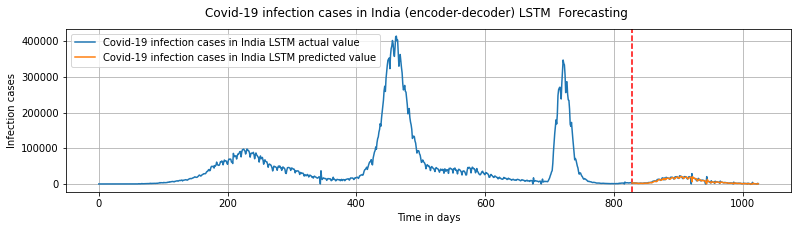

X_test MSE: 10733871.0
X_test MAE: 1721.1739501953125
X_test MAPE:766314650.0%
R-Squared: 0.7745660042194789
X_test RMSE: 3276.2587890625
X_test RRMSE: 57.23861312866211


In [65]:
# load model
save_path = 'models/{}_lstm_model.zip'.format(data_name)
model = torch.load(save_path)
model.eval()
train_predict = model(dataX.transpose(0,1),torch.zeros(1,dataX.size(0),1))
#print(train_predict.size(),dataY.size())
print(len(train_predict[0]))
train_predict = train_predict.squeeze(0)
data_predict = train_predict.data.numpy()

dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)
import warnings
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
import cufflinks
import plotly.io as pio 
plt.figure(figsize=(13, 3))
plt.axvline(x=train_len, c='r', linestyle='--')

plt.plot(dataY_plot, label = data_name + ' ' + "LSTM actual value")
x = np.arange(train_len, train_len + len(raw_data)-train_len-seq_length-1)
plt.plot(x, data_predict[train_len:],label = data_name + ' ' + "LSTM predicted value")
plt.suptitle(data_name + ' ' + '(encoder-decoder) LSTM  Forecasting')
plt.ylabel('Infection cases')
plt.xlabel('Time in days')
plt.legend()
plt.grid(True)
plt.show()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])   # 5500  
mae = mean_absolute_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])
mape = mean_absolute_percentage_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])*100
#rmsle = np.sqrt(mean_squared_log_error(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):]))
r2_Squared = r2_score(dataY_plot[(train_size+validate_size):], data_predict[(train_size+validate_size):])
rmse = np.sqrt(mse)
rrmse= np.sqrt(rmse)



print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print('X_test MAPE:{}%'.format(mape))
#print(f'X_test RMSLE: {rmsle}')
print(f'R-Squared: {r2_Squared}')
print(f'X_test RMSE: {rmse}')
print(f'X_test RRMSE: {rrmse}')

In [37]:
train_predict.data.numpy()

array([[0.00199278],
       [0.00199425],
       [0.00199331],
       ...,
       [0.00323898],
       [0.00152388],
       [0.0044679 ]], dtype=float32)

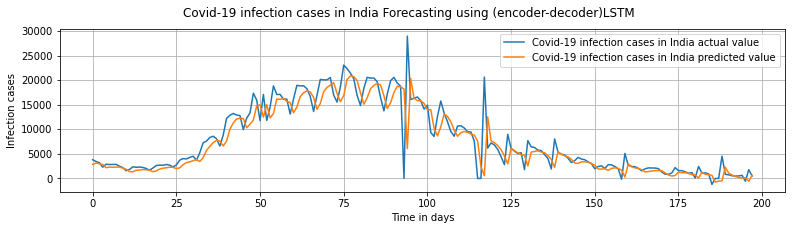

In [66]:
plt.figure(figsize=(13, 3))
plt.plot(dataY_plot[(train_size+validate_size):], label = data_name + ' ' + "actual value")
plt.plot(data_predict[(train_size+validate_size):], label = data_name + ' ' + "predicted value")
plt.suptitle(data_name + ' ' + 'Forecasting using (encoder-decoder)LSTM ')
plt.ylabel('Infection cases')
plt.xlabel('Time in days')
plt.legend()
plt.grid(True)
plt.show()
